In [1]:
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic
import networkx as nx
from sklearn.manifold import MDS
import matplotlib.animation as animation

In [2]:
CITIES = [
    "Rome",
    "Milan",
    "Naples",
    "Turin",
    "Palermo",
    "Genoa",
    "Bologna",
    "Florence",
    "Bari",
    "Catania",
    "Venice",
    "Verona",
    "Messina",
    "Padua",
    "Trieste",
    "Taranto",
    "Brescia",
    "Prato",
    "Parma",
    "Modena",
]
distance_matrix_test = np.load('lab2/test_problem.npy')

In [3]:
def isMatrixSymmetric(matrix):
    return np.allclose(matrix, matrix.T)

def doesMatrixHaveZeroDiagonal(matrix):
    return np.allclose(matrix.diagonal(), 0.0)

def doesMatrixHaveNegativeValues(matrix):
    return np.any(matrix < 0)

def isTriangleInequalitySatisfied(matrix):
    n = matrix.shape[0]
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            for k in range(n):
                if i == k or j == k:
                    continue
                if matrix[i, k] > matrix[i, j] + matrix[j, k]:
                    return False
    return True

def isValidSolution(solution_matrix):
    n = solution_matrix.shape[0]
    for i in range(n):
        if np.sum(solution_matrix[i, :]) != 1:
            return False
        if np.sum(solution_matrix[:, i]) != 1:
            return False
    if solution_matrix.trace() != 0:
        return False
    graph = nx.DiGraph(solution_matrix)
    cycles = list(nx.simple_cycles(graph))
    if len(cycles) != 1 and len(cycles[0]) != n:
        return False
    return True

def totalDistance(path, distance_matrix):
    total_distance = 0
    n = len(path)
    for i in range(n):
        j = (i + 1) % n
        total_distance += distance_matrix[path[i], path[j]]
    return total_distance

def generateRandomSolutionArray(num_cities):
    solution = list(range(num_cities))
    np.random.shuffle(solution)
    return solution

def generateGreadySolutionArray(distance_matrix, start_city=0):
    n = distance_matrix.shape[0]
    unvisited = set(range(n))
    current_city = start_city
    path = [current_city]
    unvisited.remove(current_city)
    while unvisited:
        list_available_cities_distances = [(distance_matrix[current_city][city], city) for city in unvisited]
        next_city = min(list_available_cities_distances, key=lambda x: x[0])[1]
        path.append(next_city)
        unvisited.remove(next_city)
        current_city = next_city
    return path

def generateUltraGreadySolutionArray(distance_matrix):
    n = distance_matrix.shape[0]
    path_len = float('inf')
    best_path = None
    for i in range(n):
        path = generateGreadySolutionArray(distance_matrix, start_city=i)
        current_path_len = totalDistance(path, distance_matrix)
        if current_path_len < path_len:
            path_len = current_path_len
            best_path = path
    return best_path

def distanceMatrixToCoordinates(D):
    n = D.shape[0]    # distance_matrix is n x n

    M = np.zeros_like(D)
    for i in range(n):
        for j in range(n):
            M[i, j] = 0.5 * (D[0, j]**2 + D[i, 0]**2 - D[i, j]**2)
    # Matrix decomposition
    eigenvalues, eigenvectors = np.linalg.eig(M)
    assert np.allclose(eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T, M)

    X = eigenvectors @ np.diag(np.sqrt(np.abs(eigenvalues)))
    
    # Indices where eigenvalues are too small (considered as zero or negative)
    small_eigenvalue_indices = np.where(np.abs(eigenvalues) < 1e-10)[0]
    X = np.delete(X, small_eigenvalue_indices, axis=1)
    
    return X

# Only works when the distance matrix is symmetric
def reduceDimensionality(coordinates, target_dim=2):
    mds = MDS(n_components=target_dim, dissimilarity='euclidean', random_state=42)
    reduced_coordinates = mds.fit_transform(coordinates)
    return reduced_coordinates

def plotCities2D(coordinates_2D, city_names = None, title = ""):
    plt.figure(figsize=(6, 4))
    plt.scatter(coordinates_2D[:, 0], coordinates_2D[:, 1], color='blue')
    
    num_cities = coordinates_2D.shape[0]
    
    if city_names is not None:
        assert len(city_names) == num_cities, "Number of city names must match number of cities."
        for i, city in enumerate(city_names):
            plt.text(coordinates_2D[i, 0], coordinates_2D[i, 1], city, fontsize=9, ha='right')
    
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    
def plotPath2D(coordinates_2D, path, city_names = None, title = ""):
    n = len(path)
    plotCities2D(coordinates_2D, city_names, title)
    for i in range(n):
        start_city = path[i]
        end_city = path[(i + 1) % n]
        plt.plot(
            [coordinates_2D[start_city, 0], coordinates_2D[end_city, 0]],
            [coordinates_2D[start_city, 1], coordinates_2D[end_city, 1]],
            color='blue'
        )
        
def reduceAndPlotPath(distance_matrix, path, city_names = None, title = ""):
    n = distance_matrix.shape[0]
    coordinates = distanceMatrixToCoordinates(distance_matrix)
    reduced_coordinates = reduceDimensionality(coordinates, target_dim=2)
    plotPath2D(reduced_coordinates, path, city_names, title)
    
def plotPathMatrix2D(coordinates_2D, path_matrix, city_names = None, title = ""):
    n = path_matrix.shape[0]
    plotCities2D(coordinates_2D, city_names, title)
    for i in range(n):
        for j in range(n):
            if path_matrix[i, j] == 1:
                plt.plot(
                    [coordinates_2D[i, 0], coordinates_2D[j, 0]],
                    [coordinates_2D[i, 1], coordinates_2D[j, 1]],
                    color='blue'
                )
def reduceAndPlotPathMatrix(distance_matrix, path_matrix, city_names = None, title = ""):
    n = distance_matrix.shape[0]
    coordinates = distanceMatrixToCoordinates(distance_matrix)
    reduced_coordinates = reduceDimensionality(coordinates, target_dim=2)
    plotPathMatrix2D(reduced_coordinates, path_matrix, city_names, title)

### Let's try an evolution algorithm

In [4]:
LAMBDA = 20
MU = 5

In [5]:
def generateInitialPopulation(n_cities=len(CITIES)):
    population = np.zeros((LAMBDA, n_cities), dtype=int)
    for i in range(LAMBDA):
        individual = generateRandomSolutionArray(n_cities)
        population[i] = individual
    return population

def evaluatePopulation(population, distance_matrix):
    fitness_values = np.zeros(LAMBDA)
    for i in range(LAMBDA):
        fitness_values[i] = totalDistance(population[i], distance_matrix)
    return fitness_values

def selectedParentsIndices(fitness_values):
    selected = np.argsort(fitness_values)[:MU]
    return selected

In [6]:
def swap2opt(path, i, j):
    # new_solution = path.copy()
    new_solution = path 
    new_solution[i+1:j] = path[i+1:j][::-1]
    return new_solution

def swapRandom(path, i, j):
    # new_solution = path.copy()
    new_solution = path
    new_solution[i], new_solution[j] = path[j], path[i]
    return new_solution

In [7]:
def createChildren(parents, n_cities, swap_function=swap2opt):
    n_children_per_parent = int(LAMBDA / MU)
    children = np.zeros((LAMBDA, n_cities), dtype=int)
    for i, parent in enumerate(parents):
        for j in range(n_children_per_parent):
            k, l = np.random.choice(n_cities, size=2, replace=False)
            children[i * n_children_per_parent + j] = swap_function(parent, k, l)
    return children

In [8]:
def evolutionAlgorithm(distance_matrix, num_generations=100, swap_function=swap2opt):
    n_cities = distance_matrix.shape[0]
    population = generateInitialPopulation(n_cities)

    best_fitness = float('inf')
    best_solution = None
    evolution_distance = []
    
    for generation in range(num_generations):
        
        fitness_values = evaluatePopulation(population, distance_matrix)

        selected_indices = selectedParentsIndices(fitness_values)
        
        current_fitness = np.min(fitness_values)
        evolution_distance.append(current_fitness)
        if current_fitness < best_fitness:
            best_fitness = current_fitness
            # Keep a copy of the best solution found so far
            best_solution = population[selected_indices[0]].copy()
        
        parents = population[selected_indices]
        population = createChildren(parents, n_cities, swap_function)
    
    current_fitness = evaluatePopulation(population, distance_matrix)
    if np.min(current_fitness) < best_fitness:
        best_solution = population[np.argmin(current_fitness)].copy()
        best_fitness = np.min(current_fitness)

    return best_solution, best_fitness, evolution_distance

In [9]:
def plotEvolution(distance_evolution, title=""):
    plt.figure(figsize=(6, 4))
    plt.plot(distance_evolution, color='blue')
    plt.title(title)
    plt.xlabel("Iteration")
    plt.ylabel("Best Distance")
    plt.grid()

In [10]:
path, fitness, evolution = evolutionAlgorithm(distance_matrix_test, num_generations=500, swap_function=swap2opt)

ic(path)
ic(fitness)

ic| path: array([18, 19,  6, 17,  7,  0,  2,  8, 15, 12,  9,  4,  5,  3,  1, 16, 11,
                 13, 10, 14])
ic| fitness: np.float64(3126.44)


np.float64(3126.44)

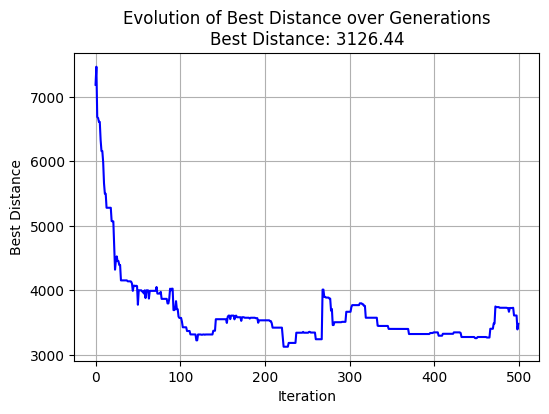

In [ ]:
plotEvolution(evolution, title=f"Evolution of Best Distance over Generations\nBest Distance: {fitness:.2f}")
# Best distance found: 3126.44